In [21]:
from PIL import Image
import cv2
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import mediapy as media

from tqdm.notebook import tqdm

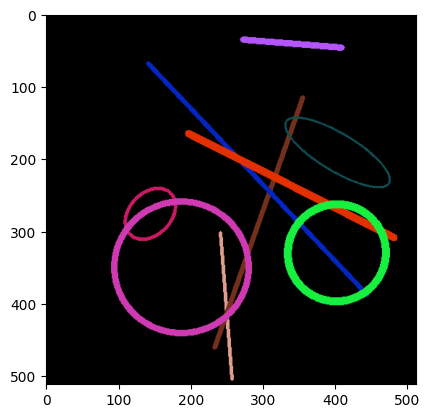

In [13]:
def generate_image_with_shapes(image_width, image_height, n_lines, m_ovals):
    image = np.zeros((image_height, image_width, 3), dtype=np.uint8) * 255

    for _ in range(n_lines):
        start_point = (random.randint(0, image_width), random.randint(0, image_height))
        end_point = (random.randint(0, image_width), random.randint(0, image_height))
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        thickness = random.randint(2, 10)
        cv2.line(image, start_point, end_point, color, thickness)

    for _ in range(m_ovals):
        center = (random.randint(0, image_width), random.randint(0, image_height))
        axes = (random.randint(20, 100), random.randint(20, 100))
        angle = random.randint(0, 360)
        startAngle = 0
        endAngle = 360
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        thickness = random.randint(2, 10)
        cv2.ellipse(image, center, axes, angle, startAngle, endAngle, color, thickness)

    return image

# Parameters
n_lines = 5
m_ovals = 4

# Generate image
image = generate_image_with_shapes(512, 512, n_lines, m_ovals)

cv2.imwrite("test_random.png", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
plt.imshow(image)

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
width = height = 128
device = "cuda"

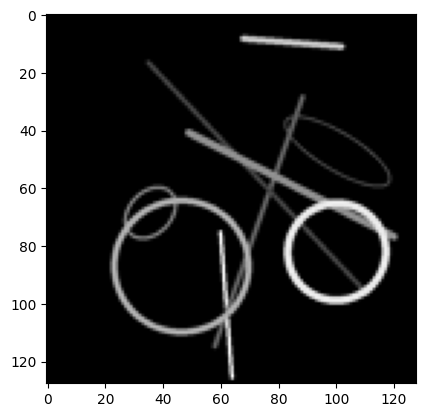

In [16]:
target_image = Image.open("test_random.png")

target_image = target_image.convert("L").resize((height, width))
plt.imshow(target_image, cmap="grey")
plt.show()

target_image = transforms.ToTensor()(target_image).to(device).squeeze(0)

In [17]:
from gaussian_model import Gaussian2DImage, combined_loss
from IPython.display import clear_output


num_gaussians = 300

num_steps = 7000
dump_every = 100
reset_every = 3000
densify_from = 500
densify_until = 15000
densify_every = 100

In [18]:
def optimization_loop(gaussian_image):

    gaussian_image.create_optimizer()
    
    for step in range(num_steps):
    
        gaussian_image.optimizer.zero_grad()

        reconstructed_image = gaussian_image()

        loss = combined_loss(reconstructed_image, target_image, lambda_param=0.2)
        loss.backward()
    
        if loss < 1e-5:
            print(f"Small loss at iter {step}")
            break
    
        if loss.isnan():
            print(f"NaNs at iter {step}")
            break
    
        gaussian_image.optimizer.step()
        gaussian_image.update_learning_rate(step)
        
        if step % dump_every == 0:
            clear_output(wait=True)
            
            result = torch.cat([
                reconstructed_image.unsqueeze(0), 
                target_image.unsqueeze(0), 
                torch.sqrt((reconstructed_image - target_image) ** 2).unsqueeze(0)
            ], dim=2)
            result = transforms.ToPILImage()(result)


            media.show_image(result)
            
            plt.figure(figsize=(10, 5))
            plt.imshow(result, cmap="grey")
            plt.title(f"step: {step}")
            plt.show()
    
        if step < densify_until:
            # clone and split gaussians
            if step >= densify_from and step % densify_every == 0:
                gaussian_image.densify_and_prune(scale_threshold=3)
        
            # reset opacities
            if step > 0 and step % reset_every == 0:
                gaussian_image.reset_opacity()

In [3]:
# gaussian_image = Gaussian2DImage(num_gaussians, width, height).to(device)
# optimization_loop(gaussian_image)

In [59]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

num_gaussians = 100

num_steps = 4000
dump_every = 100
reset_every = 3000
densify_from = 500
densify_until = 3000
densify_every = 100

scale_reg = 0.01
opacity_reg = 0.01
cap_max = 1500

noise_lr = 5000
frames = []
frames_disks = []


def plot_one_gaussian(mean, scale, theta, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # Width and height of ellipse are 2*scale (for one standard deviation)
    width = scale[0]
    height = scale[1]

    # Create and add ellipse patch
    ell = Ellipse(xy=mean, width=width, height=height, angle=math.degrees(theta), **kwargs)
    ax.add_patch(ell)


def plot_many_gaussians(gaussian_image):
    means = gaussian_image.get_means().detach().cpu().numpy()
    scales = gaussian_image.get_scales().detach().cpu().numpy()
    thetas = gaussian_image.get_thetas().detach().cpu().numpy()
    #colors = gaussian_image.get_colors().detach().cpu().numpy()

    fig, ax = plt.subplots(figsize=(10, 10))
    for mean, scale, theta in zip(means, scales, thetas):
        plot_one_gaussian(mean, 3*scale, theta, ax=ax, edgecolor="b", facecolor="none")

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_aspect("equal")
    ax.invert_yaxis()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

    return fig

def optimization_loop_mcmc(gaussian_image):

    N_before = N_relocate = N_add = gaussian_image.means.shape[0]
    N_dead_mask = 0

    gaussian_image.create_optimizer()

    losses = []
    
    for step in range(num_steps):
    
        gaussian_image.optimizer.zero_grad()

        reconstructed_image = gaussian_image()

        # Updated loss
        loss = combined_loss(reconstructed_image, target_image, lambda_param=0.2)
        loss = loss + opacity_reg * torch.abs(gaussian_image.get_opacities()).mean()
        loss = loss + scale_reg * torch.abs(gaussian_image.get_scales()).mean()
        loss.backward()

        losses.append(loss.item())
    
        if loss < 1e-5:
            print(f"Small loss at iter {step}")
            break
    
        if loss.isnan():
            print(f"NaNs at iter {step}")
            break
    
        if step < densify_until and step >= densify_from and step % densify_every == 0:
            N_before = gaussian_image.means.shape[0]
            
            dead_mask = (gaussian_image.get_opacities() <= 0.005).squeeze(-1)
            N_dead_mask = dead_mask.sum()
            
            gaussian_image.relocate_gs(dead_mask=dead_mask)
            N_relocate = gaussian_image.means.shape[0]
            
            gaussian_image.add_new_gs(cap_max=cap_max)
            N_add = gaussian_image.means.shape[0]

        gaussian_image.optimizer.step()
        means_lr = gaussian_image.update_learning_rate(step)
        
        gaussian_image.add_means_noise(noise_lr, means_lr)

        if step % dump_every == 0:
            clear_output(wait=True)

            print(f"n_gaussians before: {N_before}")
            print(f"n_gaussians after relocate: {N_relocate} with {N_dead_mask} dead")
            print(f"n_gaussians after add new: {N_add}")
            
            result = torch.cat([
                reconstructed_image.unsqueeze(0), 
                target_image.unsqueeze(0), 
                torch.sqrt((reconstructed_image - target_image) ** 2).unsqueeze(0)
            ], dim=2)
            result = transforms.ToPILImage()(result)
            #media.show_image(result)
            
            plt.figure(figsize=(10, 5))
            plt.imshow(result, cmap="grey")
            plt.title(f"step: {step}")
            plt.show()

            plt.plot(losses)
            plt.yscale("log")
            plt.show()

        result = torch.cat([
            reconstructed_image.unsqueeze(0), 
            target_image.unsqueeze(0), 
            torch.sqrt((reconstructed_image - target_image) ** 2).unsqueeze(0)
        ], dim=2)

        
        '''fig = plot_many_gaussians(gaussian_image)
        canvas = FigureCanvas(fig)
        canvas.draw()

        buf=canvas.buffer_rgba()

        frames_disks.append(np.asarray(buf)[:,:,2,:])'''

        result = transforms.ToPILImage()(result)
        result = np.array(result)
        frames.append(result)
        

        
        
    

n_gaussians before: 302
n_gaussians after relocate: 302 with 81 dead
n_gaussians after add new: 317


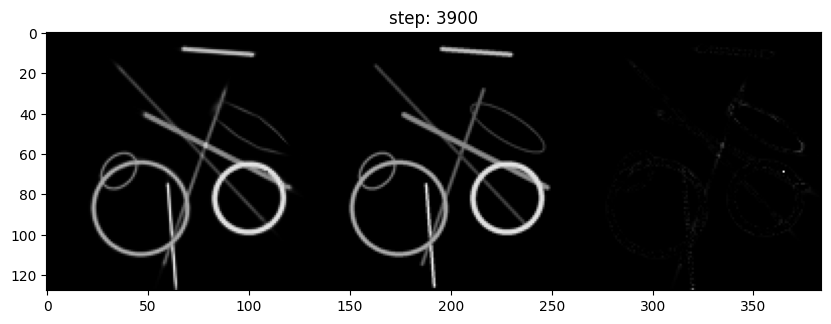

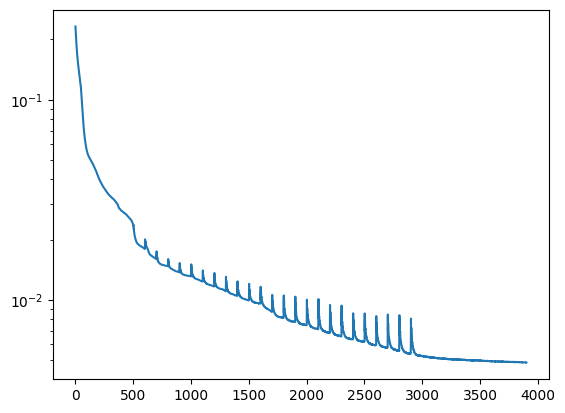

'\nwith video_disks as v_d:\n    for fig in frames_disks:\n        v_d.add_image(fig.astype(np.uint8))\n        '

In [60]:
gaussian_image = Gaussian2DImage(num_gaussians, width, height).to(device)
optimization_loop_mcmc(gaussian_image)
import os


video_lines = media.VideoWriter("video_lines.mp4", fps=60, shape=(height, 3*width))
video_disks = media.VideoWriter("video_disks.mp4", fps=60, shape=(1000, 1000))

with video_lines as v:
    for frame in frames:
        
        v.add_image(frame)

'''
with video_disks as v_d:
    for fig in frames_disks:
        v_d.add_image(fig.astype(np.uint8))
        '''

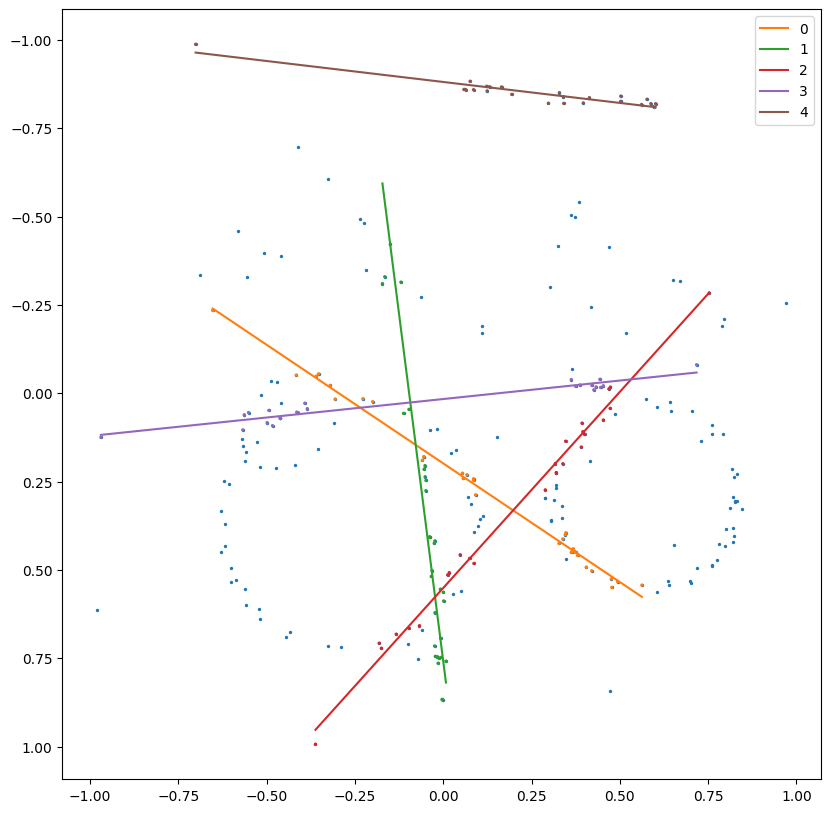

In [44]:

from skimage.measure import ransac, LineModelND

points = gaussian_image.get_means().detach().cpu().numpy()

# screen space mask
mask = (points[:, 0] >= -1) & (points[:, 0] <= 1) & (points[:, 1] >= -1) & (points[:, 1] <= 1)
points = points[mask]

X = points[:, 0]
y = points[:, 1]

plt.figure(figsize=(10, 10))
plt.scatter(X, y, s=2)

ax = plt.gca()
ax.set_aspect("equal")
ax.invert_yaxis()

n_runs = n_lines
for i in range(n_runs):  
    model_robust, inliers = ransac(points, LineModelND, min_samples=2, residual_threshold=0.03, max_trials=1000)
    
    line_X = np.linspace(X[inliers].min(), X[inliers].max())
    line_y_ransac = model_robust.predict_y(line_X)

    color = f"C{i+1}"
    plt.scatter(X[inliers], y[inliers], s=2, c=[color] * len(y[inliers]))
    plt.plot(line_X, line_y_ransac, c=color, label=i)

    # select the remaining data
    X = X[~inliers]
    y = y[~inliers]
    points = points[~inliers]

plt.legend()
plt.show()

In [45]:

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math


def plot_one_gaussian(mean, scale, theta, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # Width and height of ellipse are 2*scale (for one standard deviation)
    width = scale[0]
    height = scale[1]

    # Create and add ellipse patch
    ell = Ellipse(xy=mean, width=width, height=height, angle=math.degrees(theta), **kwargs)
    ax.add_patch(ell)


def plot_many_gaussians(gaussian_image):
    means = gaussian_image.get_means().detach().cpu().numpy()
    scales = gaussian_image.get_scales().detach().cpu().numpy()
    thetas = gaussian_image.get_thetas().detach().cpu().numpy()
    #colors = gaussian_image.get_colors().detach().cpu().numpy()

    fig, ax = plt.subplots(figsize=(10, 10))
    for mean, scale, theta in zip(means, scales, thetas):
        plot_one_gaussian(mean, 3*scale, theta, ax=ax, edgecolor="b", facecolor="none")

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_aspect("equal")
    ax.invert_yaxis()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

    return fig

/tmp/ipykernel_363784/65221039.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ell = Ellipse(xy=mean, width=width, height=height, angle=math.degrees(theta), **kwargs)


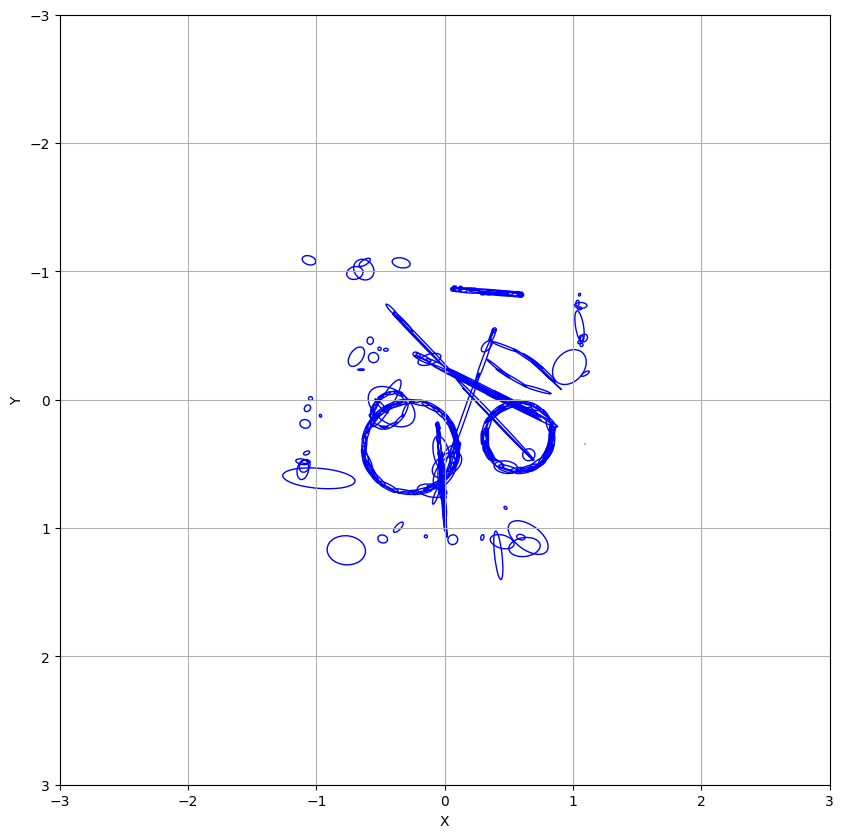

In [39]:
fig = plot_many_gaussians(gaussian_image)
fig.savefig("gaussians.png")